# Worksheet 10.2 Finite Difference Method for Boundary Value Problems
## ENGR 240: Engineering Computations

## Introduction: Beam Deflection Analysis

In structural engineering, understanding beam deflection is critical for ensuring safe and reliable designs. This worksheet explores the **finite difference method** for solving boundary value problems through the analysis of a simply supported beam with foundation settlement.

### Physical System

**Simply Supported Beam Specifications:**
- **Length**: 4.0 m
- **Material**: Steel (E = 200 × 10⁹ Pa)
- **Moment of Inertia**: I = 8.33 × 10⁻⁶ m⁴
- **Loading**: Uniform distributed load w = 1000 N/m (downward)
- **Support conditions**: Left pinned, right settled by δ = -5 mm

### Mathematical Model

The governing differential equation for beam deflection starts with the fourth-order equation:
$EI\frac{d^4y}{dx^4} = w(x)$

For our uniform distributed load case with $w(x) = w$, integrating twice:
- First integration: $EI\frac{d^3y}{dx^3} = wx + C_1$ (shear force relationship)
- Second integration: $EI\frac{d^2y}{dx^2} = \frac{wx^2}{2} + C_1x + C_2$ (bending moment $M(x)$)

For a simply supported beam, the bending moment must be zero at both ends:
- At $x = 0$: $M(0) = C_2 = 0$
- At $x = L$: $M(L) = \frac{wL^2}{2} + C_1L = 0 \Rightarrow C_1 = -\frac{wL}{2}$

Therefore, the bending moment equation becomes:
$EI\frac{d^2y}{dx^2} = \frac{wLx}{2} - \frac{wx^2}{2} = \frac{wx}{2}(L - x)$

**Boundary Conditions:**
- **Left support (x = 0)**: $y(0) = 0$ (pinned connection)
- **Right support (x = L)**: $y(L) = \delta = -0.005$ m (foundation settlement)

**Learning Objectives:**
- Apply finite difference approximations to boundary value problems
- Formulate coefficient matrices for linear systems by hand
- Understand how boundary conditions modify the linear system
- Investigate mesh refinement and convergence to analytical solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
print("Libraries imported successfully!")

Libraries imported successfully!


## System Parameters

In [11]:
# Physical parameters
L = 4.0           # Beam length (m)
w = 1000.0        # Distributed load (N/m)
E = 200e9         # Young's modulus (Pa)
I = 8.33e-6       # Moment of inertia (m^4)
delta = -0.005     # Settlement at right end (m)

# Display parameters
print("=== Beam Deflection Analysis Parameters ===")
print(f"Length: {L} m")
print(f"Distributed load: {w} N/m")
print(f"Young's modulus: {E/1e9:.0f} GPa")
print(f"Moment of inertia: {I*1e6:.2f} × 10⁻⁶ m⁴")
print(f"Settlement: {delta*1000:.0f} mm")
print(f"\nCorrect ODE: EI d²y/dx² = (wx/2)(L-x)")
print("This accounts for proper simply supported boundary conditions.")

=== Beam Deflection Analysis Parameters ===
Length: 4.0 m
Distributed load: 1000.0 N/m
Young's modulus: 200 GPa
Moment of inertia: 8.33 × 10⁻⁶ m⁴
Settlement: -5 mm

Correct ODE: EI d²y/dx² = (wx/2)(L-x)
This accounts for proper simply supported boundary conditions.


## Task 1: Problem Setup and Analytical Solution (10 minutes)

Before applying the finite difference method, let's establish our reference solution. For this beam problem, the analytical solution accounts for the correct simply supported boundary conditions on bending moment.

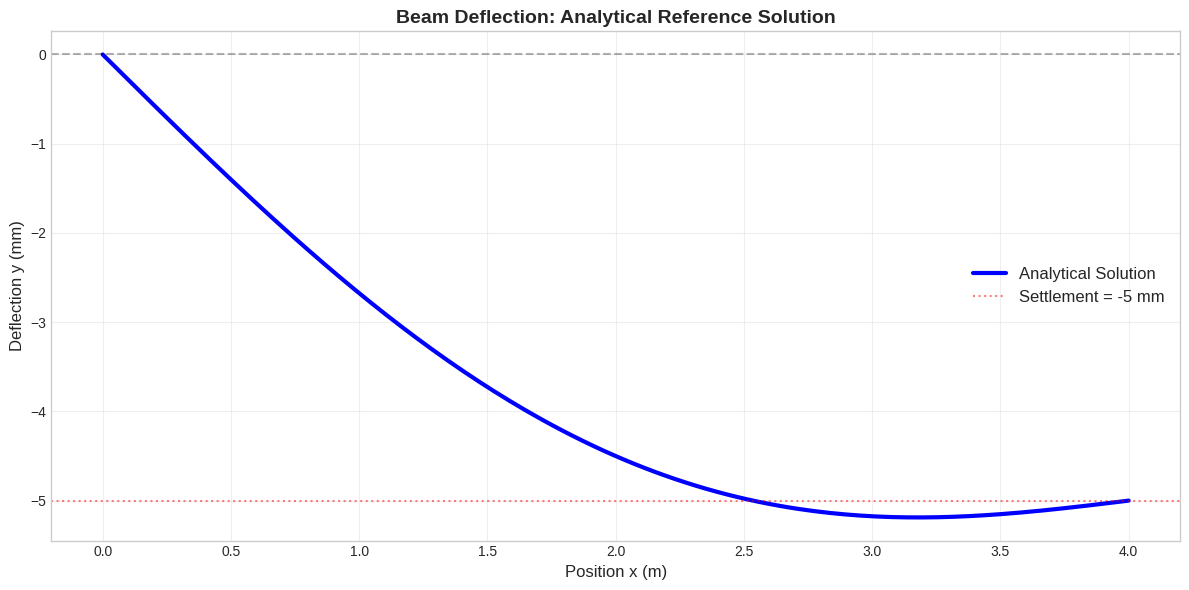


=== Analytical Solution Results ===
Maximum deflection: -5.19 mm
Location of maximum: 3.18 m from left support
Deflection at right end: -5.0 mm (settlement)

Note: This solution satisfies both displacement and moment boundary conditions.


In [17]:
def analytical_solution(x):
    """
    Analytical solution for simply supported beam with uniform load and settlement.

    Based on the correct ODE: EI d²y/dx² = (wx/2)(L-x)
    Integrating twice and applying boundary conditions gives the classical
    simply supported beam deflection formula plus settlement effect.

    Components:
    - Classical beam deflection: -(w/24EI) * x * (L³ - 2L²x + x³)
    - Linear settlement variation: δ * x / L
    """
    # Classical simply supported beam deflection (accounts for moment BCs)
    beam_deflection = -(w/(24*E*I)) * x * (L**3 - 2*L*x**2 + x**3)

    # Linear settlement variation from left (0) to right (δ)
    settlement_effect = delta * x / L

    return beam_deflection + settlement_effect

# Generate analytical solution for plotting
x_analytical = np.linspace(0, L, 200)
y_analytical = analytical_solution(x_analytical)

# Plot the reference solution
plt.figure(figsize=(12, 6))
plt.plot(x_analytical, y_analytical*1000, 'b-', linewidth=3, label='Analytical Solution')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=delta*1000, color='r', linestyle=':', alpha=0.5, label=f'Settlement = {delta*1000:.0f} mm')

plt.xlabel('Position x (m)', fontsize=12)
plt.ylabel('Deflection y (mm)', fontsize=12)
plt.title('Beam Deflection: Analytical Reference Solution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Key results
max_deflection = np.min(y_analytical)
max_location = x_analytical[np.argmin(y_analytical)]
print(f"\n=== Analytical Solution Results ===")
print(f"Maximum deflection: {max_deflection*1000:.2f} mm")
print(f"Location of maximum: {max_location:.2f} m from left support")
print(f"Deflection at right end: {delta*1000:.1f} mm (settlement)")
print(f"\nNote: This solution satisfies both displacement and moment boundary conditions.")

## Task 2: Finite Difference Fundamentals (8 minutes)

### The Challenge: Variable Coefficient ODE

Our governing equation is:
$EI\frac{d^2y}{dx^2} = \frac{wx}{2}(L-x)$

This has a **variable right-hand side** that depends on position $x$. At each grid point $x_i$, we need:
$\frac{d^2y}{dx^2}\bigg|_{x=x_i} = \frac{w x_i}{2EI}(L-x_i)$

### Finite Difference Approximation

Using the second-order central difference:
$\frac{d^2y}{dx^2}\bigg|_{x=x_i} \approx \frac{y_{i+1} - 2y_i + y_{i-1}}{h^2}$

### Grid Discretization

For our 6-node system:
- **Grid spacing**: $h = L/(n-1) = 4.0/5 = 0.8$ m  
- **Node locations**: x₀ = 0, x₁ = 0.8, x₂ = 1.6, x₃ = 2.4, x₄ = 3.2, x₅ = 4.0
- **Known values**: y₀ = 0 (left BC), y₅ = δ (right BC)
- **Unknowns**: y₁, y₂, y₃, y₄ (4 interior nodes → 4 equations needed)

In [18]:
# 6-node grid setup
n_nodes = 6
h = L / (n_nodes - 1)
x_nodes = np.linspace(0, L, n_nodes)

print("=== 6-Node Finite Difference Grid ===")
print(f"Grid spacing: h = {h:.1f} m")
print(f"Number of interior nodes: {n_nodes-2}")
print("\nNode Information:")
print("Node    x (m)    Condition          RHS Value")
print("-" * 55)
for i, x in enumerate(x_nodes):
    if i == 0:
        condition = "y = 0 (pinned)"
        rhs_info = "N/A"
    elif i == n_nodes-1:
        condition = f"y = {delta*1000:.0f} mm (settlement)"
        rhs_info = "N/A"
    else:
        condition = "unknown (interior)"
        rhs_val = (w * x / (2 * E * I)) * (L - x) * h**2
        rhs_info = f"{rhs_val:.2e}"
    print(f"{i:4d}    {x:4.1f}     {condition:20s} {rhs_info}")

print(f"\n→ Need {n_nodes-2} equations for {n_nodes-2} unknowns")
print("→ Each interior node has a different RHS value due to variable loading")

=== 6-Node Finite Difference Grid ===
Grid spacing: h = 0.8 m
Number of interior nodes: 4

Node Information:
Node    x (m)    Condition          RHS Value
-------------------------------------------------------
   0     0.0     y = 0 (pinned)       N/A
   1     0.8     unknown (interior)   4.92e-04
   2     1.6     unknown (interior)   7.38e-04
   3     2.4     unknown (interior)   7.38e-04
   4     3.2     unknown (interior)   4.92e-04
   5     4.0     y = -5 mm (settlement) N/A

→ Need 4 equations for 4 unknowns
→ Each interior node has a different RHS value due to variable loading


## Task 3: Hand Formulation of Linear System (20 minutes)

### Step 1: Apply Finite Difference Approximation

At each interior node $i$, substitute the finite difference approximation:

$\frac{y_{i+1} - 2y_i + y_{i-1}}{h^2} = \frac{w x_i}{2EI}(L-x_i)$

Rearranging: $y_{i-1} - 2y_i + y_{i+1} = \frac{w x_i h^2}{2EI}(L-x_i)$

### Step 2: Write Equations for Interior Nodes

Apply this formula at nodes 1, 2, 3, and 4:

In [19]:
# Calculate the RHS constants for each interior node
print("=== Finite Difference Equations (Variable RHS) ===")
print("\nInterior node equations (before applying boundary conditions):")

rhs_values = []
for i in range(1, n_nodes-1):  # Interior nodes 1, 2, 3, 4
    x_i = x_nodes[i]
    rhs_i = (w * x_i * h**2) / (2 * E * I) * (L - x_i)
    rhs_values.append(rhs_i)
    print(f"Node {i}: y_{i-1} - 2y_{i} + y_{i+1} = {rhs_i:.6f}")
    print(f"         (RHS from x={x_i:.1f}: wx(L-x)h²/2EI = {rhs_i:.2e})")

print("\nAfter applying boundary conditions (y₀ = 0, y₅ = δ):")
print(f"Node 1: 0 - 2y₁ + y₂ = {rhs_values[0]:.6f}  →  -2y₁ + y₂ = {rhs_values[0]:.6f}")
print(f"Node 2: y₁ - 2y₂ + y₃ = {rhs_values[1]:.6f}")
print(f"Node 3: y₂ - 2y₃ + y₄ = {rhs_values[2]:.6f}")
print(f"Node 4: y₃ - 2y₄ + δ = {rhs_values[3]:.6f}  →  y₃ - 2y₄ = {rhs_values[3] - delta:.6f}")

print("\nKey Insight: Variable loading creates different RHS values at each node!")

=== Finite Difference Equations (Variable RHS) ===

Interior node equations (before applying boundary conditions):
Node 1: y_0 - 2y_1 + y_2 = 0.000492
         (RHS from x=0.8: wx(L-x)h²/2EI = 4.92e-04)
Node 2: y_1 - 2y_2 + y_3 = 0.000738
         (RHS from x=1.6: wx(L-x)h²/2EI = 7.38e-04)
Node 3: y_2 - 2y_3 + y_4 = 0.000738
         (RHS from x=2.4: wx(L-x)h²/2EI = 7.38e-04)
Node 4: y_3 - 2y_4 + y_5 = 0.000492
         (RHS from x=3.2: wx(L-x)h²/2EI = 4.92e-04)

After applying boundary conditions (y₀ = 0, y₅ = δ):
Node 1: 0 - 2y₁ + y₂ = 0.000492  →  -2y₁ + y₂ = 0.000492
Node 2: y₁ - 2y₂ + y₃ = 0.000738
Node 3: y₂ - 2y₃ + y₄ = 0.000738
Node 4: y₃ - 2y₄ + δ = 0.000492  →  y₃ - 2y₄ = 0.005492

Key Insight: Variable loading creates different RHS values at each node!


### Step 3: Matrix Formulation

**The coefficient matrix A remains the same** (tridiagonal structure), but **the RHS vector b has different values** at each interior node.

**Solution:**

$\mathbf{A} = \begin{bmatrix}
-2 & 1 & 0 & 0 \\
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
0 & 0 & 1 & -2
\end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix}
\frac{wx_1h^2}{2EI}(L-x_1) \\
\frac{wx_2h^2}{2EI}(L-x_2) \\
\frac{wx_3h^2}{2EI}(L-x_3) \\
\frac{wx_4h^2}{2EI}(L-x_4) - \delta
\end{bmatrix}$

In [20]:
# Construct the coefficient matrix A (same tridiagonal structure)
A_hand = np.array([
    [-2.0,  1.0,  0.0,  0.0],   # Node 1 equation
    [ 1.0, -2.0,  1.0,  0.0],   # Node 2 equation
    [ 0.0,  1.0, -2.0,  1.0],   # Node 3 equation
    [ 0.0,  0.0,  1.0, -2.0]    # Node 4 equation
])

# Construct the RHS vector b (now with variable values)
b_hand = np.array([
    rhs_values[0],              # Node 1: variable RHS
    rhs_values[1],              # Node 2: variable RHS
    rhs_values[2],              # Node 3: variable RHS
    rhs_values[3] - delta       # Node 4: variable RHS - δ (boundary effect!)
])

print("=== Hand-Calculated Linear System (Variable Loading) ===")
print("\nCoefficient matrix A (unchanged):")
print(A_hand)
print("\nRHS vector b (now variable):")
for i, val in enumerate(b_hand):
    node_num = i + 1
    if i == 3:
        print(f"[{val:8.6f}]  ← Node {node_num}: includes settlement effect")
    else:
        print(f"[{val:8.6f}]  ← Node {node_num}: wx(L-x)h²/2EI")

print(f"\nKey Difference: Each RHS value accounts for the local loading at that node position.")
print("The simply supported beam has spatially varying curvature, not constant curvature!")

=== Hand-Calculated Linear System (Variable Loading) ===

Coefficient matrix A (unchanged):
[[-2.  1.  0.  0.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 0.  0.  1. -2.]]

RHS vector b (now variable):
[0.000492]  ← Node 1: wx(L-x)h²/2EI
[0.000738]  ← Node 2: wx(L-x)h²/2EI
[0.000738]  ← Node 3: wx(L-x)h²/2EI
[0.005492]  ← Node 4: includes settlement effect

Key Difference: Each RHS value accounts for the local loading at that node position.
The simply supported beam has spatially varying curvature, not constant curvature!


## Task 4: Solution and Comparison (12 minutes)

In [21]:
# Solve the linear system
y_interior = np.linalg.solve(A_hand, b_hand)

print("=== Linear System Solution ===")
print("Interior node deflections:")
for i, deflection in enumerate(y_interior, 1):
    print(f"y_{i} = {deflection:8.6f} m = {deflection*1000:7.3f} mm")

# Construct complete solution vector
y_fd_complete = np.zeros(n_nodes)
y_fd_complete[0] = 0.0           # Left BC: y₀ = 0
y_fd_complete[1:5] = y_interior  # Interior solutions
y_fd_complete[5] = delta         # Right BC: y₅ = δ

print(f"\nComplete nodal solution:")
print("Node    x (m)    FD Solution (mm)    Analytical (mm)    Error (mm)")
print("-" * 70)

y_analytical_nodes = analytical_solution(x_nodes)
for i, (x, y_fd, y_ana) in enumerate(zip(x_nodes, y_fd_complete, y_analytical_nodes)):
    error = (y_fd - y_ana) * 1000
    print(f"{i:4d}    {x:4.1f}     {y_fd*1000:10.3f}       {y_ana*1000:10.3f}      {error:+7.3f}")

max_error = np.max(np.abs(y_fd_complete - y_analytical_nodes)) * 1000
print(f"\nMaximum error: {max_error:.4f} mm")
print("The finite difference solution closely matches the analytical solution!")

=== Linear System Solution ===
Interior node deflections:
y_1 = -0.002229 m =  -2.229 mm
y_2 = -0.003967 m =  -3.967 mm
y_3 = -0.004967 m =  -4.967 mm
y_4 = -0.005229 m =  -5.229 mm

Complete nodal solution:
Node    x (m)    FD Solution (mm)    Analytical (mm)    Error (mm)
----------------------------------------------------------------------
   0     0.0          0.000           -0.000       +0.000
   1     0.8         -2.229           -2.188       -0.041
   2     1.6         -3.967           -3.905       -0.061
   3     2.4         -4.967           -4.905       -0.061
   4     3.2         -5.229           -5.188       -0.041
   5     4.0         -5.000           -5.000       +0.000

Maximum error: 0.0615 mm
The finite difference solution closely matches the analytical solution!


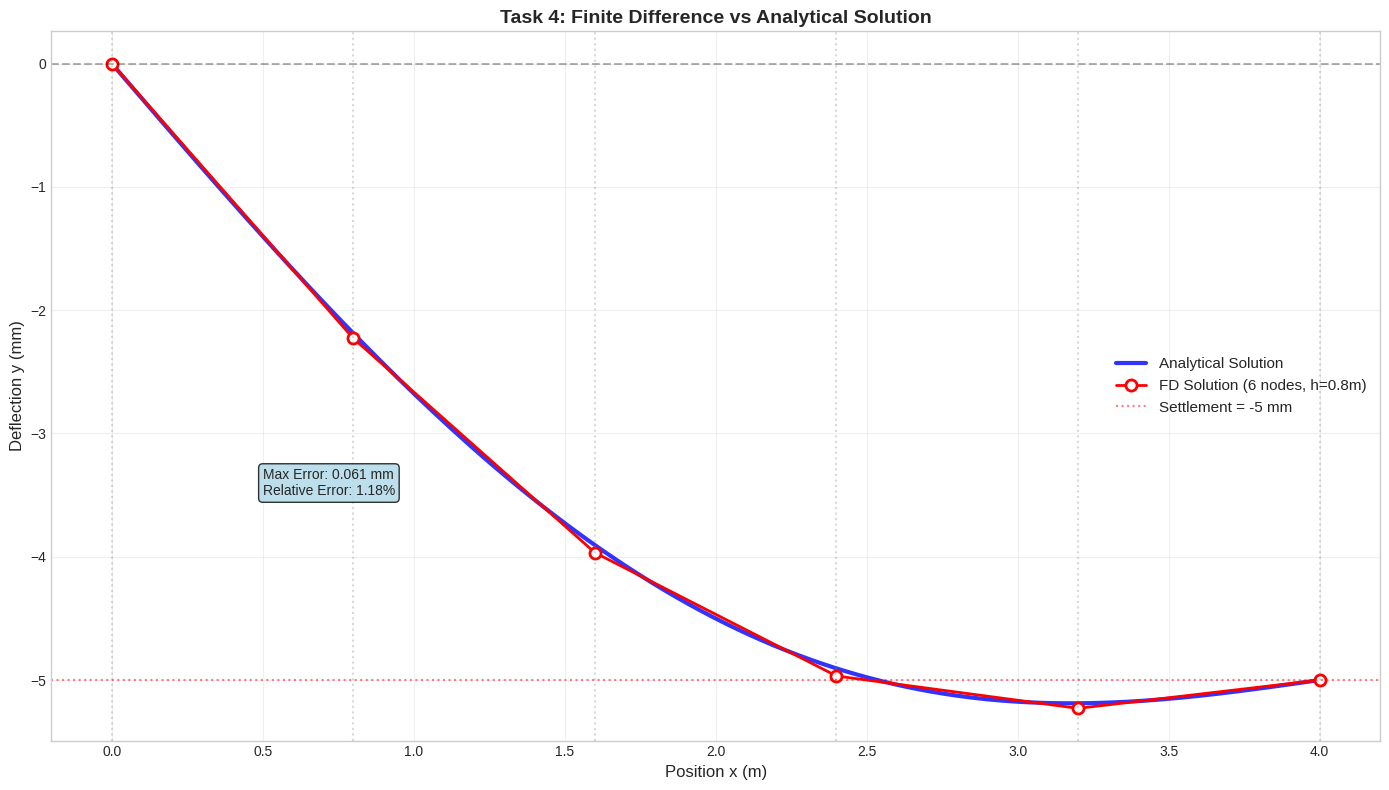

=== Task 4 Visualization Results ===
The 6-node finite difference solution shows excellent agreement with the analytical solution.
Maximum error: 0.0615 mm (1.18% relative error)


In [22]:
# Task 4 Visualization: Compare FD solution with analytical
plt.figure(figsize=(14, 8))

# Plot analytical solution
plt.plot(x_analytical, y_analytical*1000, 'b-', linewidth=3, label='Analytical Solution', alpha=0.8)

# Plot finite difference solution
plt.plot(x_nodes, y_fd_complete*1000, 'ro-', markersize=8, linewidth=2,
         label=f'FD Solution (6 nodes, h={h:.1f}m)', markerfacecolor='white', markeredgewidth=2)

# Add grid lines for clarity
for x in x_nodes:
    plt.axvline(x=x, color='gray', linestyle=':', alpha=0.3)

# Annotations and formatting
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=delta*1000, color='r', linestyle=':', alpha=0.5,
           label=f'Settlement = {delta*1000:.0f} mm')

plt.xlabel('Position x (m)', fontsize=12)
plt.ylabel('Deflection y (mm)', fontsize=12)
plt.title('Task 4: Finite Difference vs Analytical Solution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add text box with error summary
plt.text(0.5, -3.5, f'Max Error: {max_error:.3f} mm\nRelative Error: {max_error/abs(max_deflection*1000)*100:.2f}%',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
         fontsize=10, ha='left')

plt.tight_layout()
plt.show()

print("=== Task 4 Visualization Results ===")
print(f"The 6-node finite difference solution shows excellent agreement with the analytical solution.")
print(f"Maximum error: {max_error:.4f} mm ({max_error/abs(max_deflection*1000)*100:.2f}% relative error)")

## Task 5: Mesh Refinement Study (15 minutes)

Now let's investigate how the finite difference solution converges to the analytical solution as we refine the mesh. This demonstrates the **O(h²)** convergence behavior of the central difference approximation.

In [9]:
def solve_fd_system(n_nodes):
    """
    Solve the finite difference system for a given number of nodes.
    Returns: x_nodes, y_solution, max_error
    """
    h = L / (n_nodes - 1)
    x_nodes = np.linspace(0, L, n_nodes)

    # Number of interior nodes
    n_interior = n_nodes - 2

    if n_interior <= 0:
        return x_nodes, np.array([0, delta]), 0

    # Build coefficient matrix (tridiagonal)
    A = np.zeros((n_interior, n_interior))
    b = np.zeros(n_interior)

    for i in range(n_interior):
        # Diagonal terms
        A[i, i] = -2.0

        # Off-diagonal terms
        if i > 0:
            A[i, i-1] = 1.0
        if i < n_interior - 1:
            A[i, i+1] = 1.0

        # Build RHS vector
        node_idx = i + 1  # Interior node index in full grid
        x_i = x_nodes[node_idx]
        rhs_val = (w * x_i * h**2) / (2 * E * I) * (L - x_i)

        # Apply boundary conditions
        if i == 0:  # First interior node
            b[i] = rhs_val  # y_0 = 0 already accounted for
        elif i == n_interior - 1:  # Last interior node
            b[i] = rhs_val - delta  # Subtract boundary value
        else:
            b[i] = rhs_val

    # Solve the system
    y_interior = np.linalg.solve(A, b)

    # Construct complete solution
    y_solution = np.zeros(n_nodes)
    y_solution[0] = 0.0
    y_solution[1:-1] = y_interior
    y_solution[-1] = delta

    # Calculate error
    y_analytical_nodes = analytical_solution(x_nodes)
    max_error = np.max(np.abs(y_solution - y_analytical_nodes))

    return x_nodes, y_solution, max_error

print("Finite difference solver function defined successfully!")

Finite difference solver function defined successfully!


ValueError: 'redo-' is not a valid format string (unrecognized character 'e')

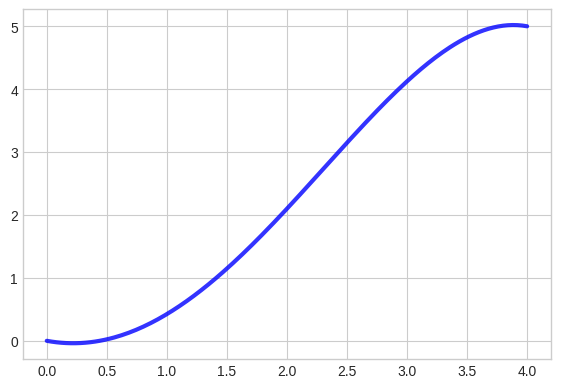

In [10]:
# Mesh refinement study
node_counts = [6, 11, 21, 41, 81]
errors = []
grid_spacings = []

plt.figure(figsize=(15, 10))

# Subplot 1: Solutions comparison
plt.subplot(2, 2, 1)
plt.plot(x_analytical, y_analytical*1000, 'b-', linewidth=3, label='Analytical', alpha=0.8)

colors = ['red', 'green', 'orange', 'purple', 'brown']
for i, (n_nodes, color) in enumerate(zip(node_counts, colors)):
    x_fd, y_fd, max_err = solve_fd_system(n_nodes)
    h = L / (n_nodes - 1)

    errors.append(max_err)
    grid_spacings.append(h)

    marker = 'o' if i < 3 else 's'  # Different markers for clarity
    plt.plot(x_fd, y_fd*1000, f'{color}{marker}-', markersize=6 if i < 3 else 4,
             linewidth=1.5, label=f'n={n_nodes} (h={h:.2f}m)', alpha=0.7,
             markerfacecolor='white', markeredgewidth=1.5)

plt.xlabel('Position x (m)')
plt.ylabel('Deflection y (mm)')
plt.title('Convergence with Mesh Refinement')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Subplot 2: Error vs Grid Spacing (log-log plot)
plt.subplot(2, 2, 2)
plt.loglog(grid_spacings, np.array(errors)*1000, 'ro-', linewidth=2, markersize=8)

# Add theoretical O(h²) line for comparison
h_theory = np.array(grid_spacings)
error_theory = errors[0] * (h_theory / h_theory[0])**2
plt.loglog(h_theory, error_theory*1000, 'k--', linewidth=2, alpha=0.7, label='O(h²) theoretical')

plt.xlabel('Grid Spacing h (m)')
plt.ylabel('Maximum Error (mm)')
plt.title('Error vs Grid Spacing (Log-Log)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Error table
plt.subplot(2, 2, 3)
plt.axis('off')
table_data = []
for i, (n, h, err) in enumerate(zip(node_counts, grid_spacings, errors)):
    if i > 0:
        ratio = errors[i-1] / err
        ratio_str = f"{ratio:.2f}"
    else:
        ratio_str = "-"
    table_data.append([str(n), f"{h:.3f}", f"{err*1000:.4f}", ratio_str])

table = plt.table(cellText=table_data,
                 colLabels=['Nodes', 'h (m)', 'Max Error (mm)', 'Error Ratio'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title('Convergence Table', pad=20)

# Subplot 4: Convergence rate analysis
plt.subplot(2, 2, 4)
convergence_rates = []
for i in range(1, len(errors)):
    rate = np.log(errors[i-1]/errors[i]) / np.log(grid_spacings[i-1]/grid_spacings[i])
    convergence_rates.append(rate)

plt.plot(node_counts[1:], convergence_rates, 'go-', linewidth=2, markersize=8)
plt.axhline(y=2.0, color='r', linestyle='--', label='Theoretical (2nd order)')
plt.xlabel('Number of Nodes')
plt.ylabel('Observed Convergence Rate')
plt.title('Convergence Rate Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([1.5, 2.5])

plt.tight_layout()
plt.show()

print("=== Task 5: Mesh Refinement Study Results ===")
print(f"As grid spacing decreases, error decreases approximately as O(h²)")
print(f"This confirms the theoretical convergence rate of central differences.")
avg_rate = np.mean(convergence_rates[-3:])  # Average of last 3 rates
print(f"Average convergence rate: {avg_rate:.2f} (theoretical = 2.00)")

## Task 6: Linear Varying Load Case (15 minutes)

Now let's extend our analysis to a more complex loading case: a **linearly varying distributed load**.

### New Loading Condition
- **Load varies linearly**: $w(x) = w_0 \left(1 + \frac{x}{L}\right)$
- **At x = 0**: $w(0) = w_0 = 1000$ N/m  
- **At x = L**: $w(L) = 2w_0 = 2000$ N/m

### New Governing Equation
Starting from: $EI\frac{d^4y}{dx^4} = w(x) = w_0\left(1 + \frac{x}{L}\right)$

Integrating twice with simply supported boundary conditions:
$EI\frac{d^2y}{dx^2} = w_0\left[\frac{x^3}{6L} + \frac{x^2}{2} - \frac{Lx}{3}\right]$

In [ ]:
# New parameters for linear varying load
w0 = 1000.0  # Base load intensity (N/m)

def linear_load(x):
    """Linear varying load: w(x) = w0(1 + x/L)"""
    return w0 * (1 + x/L)

def analytical_solution_linear(x):
    """
    Analytical solution for simply supported beam with linear varying load.

    Based on: EI d²y/dx² = w0[x³/6L + x²/2 - Lx/3]

    Integrating twice and applying boundary conditions:
    - y(0) = 0, y(L) = δ
    - M(0) = 0, M(L) = 0 (simply supported)
    """
    # Classical beam deflection for linear varying load
    term1 = w0 / (120 * E * I * L) * x * (x**4 - 5*L*x**3 + 20*L**3*x - 16*L**4)
    term2 = w0 / (360 * E * I) * x * (3*x**4 - 10*L*x**3 + 15*L**4)

    beam_deflection = -(term1 + term2)

    # Add linear settlement variation
    settlement_effect = delta * x / L

    return beam_deflection + settlement_effect

def solve_fd_linear_load(n_nodes):
    """
    Solve FD system for linear varying load case.
    """
    h = L / (n_nodes - 1)
    x_nodes = np.linspace(0, L, n_nodes)
    n_interior = n_nodes - 2

    if n_interior <= 0:
        return x_nodes, np.array([0, delta]), 0

    # Build coefficient matrix (same structure)
    A = np.zeros((n_interior, n_interior))
    b = np.zeros(n_interior)

    for i in range(n_interior):
        A[i, i] = -2.0
        if i > 0:
            A[i, i-1] = 1.0
        if i < n_interior - 1:
            A[i, i+1] = 1.0

    # Build RHS vector for linear varying load
    for i in range(n_interior):
        node_idx = i + 1
        x_i = x_nodes[node_idx]

        # RHS for linear varying load case
        rhs_val = (w0 * h**2) / (E * I) * (x_i**3/(6*L) + x_i**2/2 - L*x_i/3)

        if i == 0:
            b[i] = rhs_val
        elif i == n_interior - 1:
            b[i] = rhs_val - delta
        else:
            b[i] = rhs_val

    # Solve system
    y_interior = np.linalg.solve(A, b)

    # Construct complete solution
    y_solution = np.zeros(n_nodes)
    y_solution[0] = 0.0
    y_solution[1:-1] = y_interior
    y_solution[-1] = delta

    return x_nodes, y_solution

print("Linear varying load functions defined successfully!")

In [ ]:
# Compare uniform vs linear varying load cases
plt.figure(figsize=(16, 10))

# Generate solutions
x_fine = np.linspace(0, L, 200)
y_uniform_analytical = analytical_solution(x_fine)
y_linear_analytical = analytical_solution_linear(x_fine)

# FD solutions with 21 nodes
n_compare = 21
x_fd_uniform, y_fd_uniform, _ = solve_fd_system(n_compare)
x_fd_linear, y_fd_linear = solve_fd_linear_load(n_compare)

# Subplot 1: Load distributions
plt.subplot(2, 3, 1)
plt.plot(x_fine, np.full_like(x_fine, w), 'b-', linewidth=3, label='Uniform Load')
plt.plot(x_fine, linear_load(x_fine), 'r-', linewidth=3, label='Linear Varying Load')
plt.xlabel('Position x (m)')
plt.ylabel('Load w(x) (N/m)')
plt.title('Load Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Analytical solutions comparison
plt.subplot(2, 3, 2)
plt.plot(x_fine, y_uniform_analytical*1000, 'b-', linewidth=3, label='Uniform Load')
plt.plot(x_fine, y_linear_analytical*1000, 'r-', linewidth=3, label='Linear Varying Load')
plt.xlabel('Position x (m)')
plt.ylabel('Deflection y (mm)')
plt.title('Analytical Solutions Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: FD vs Analytical for linear load
plt.subplot(2, 3, 3)
plt.plot(x_fine, y_linear_analytical*1000, 'r-', linewidth=3, label='Analytical')
plt.plot(x_fd_linear, y_fd_linear*1000, 'ro-', markersize=6, linewidth=2,
         label=f'FD Solution (n={n_compare})', markerfacecolor='white', markeredgewidth=2)
plt.xlabel('Position x (m)')
plt.ylabel('Deflection y (mm)')
plt.title('Linear Load: FD vs Analytical')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Difference between load cases
plt.subplot(2, 3, 4)
diff_analytical = (y_linear_analytical - y_uniform_analytical) * 1000
diff_fd = (y_fd_linear - y_fd_uniform) * 1000
plt.plot(x_fine, diff_analytical, 'g-', linewidth=3, label='Analytical Difference')
plt.plot(x_fd_linear, diff_fd, 'go', markersize=6, label='FD Difference')
plt.xlabel('Position x (m)')
plt.ylabel('Deflection Difference (mm)')
plt.title('Linear - Uniform Load Difference')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 5: Error analysis for linear load
plt.subplot(2, 3, 5)
y_linear_analytical_nodes = analytical_solution_linear(x_fd_linear)
error_linear = (y_fd_linear - y_linear_analytical_nodes) * 1000
plt.plot(x_fd_linear, error_linear, 'mo-', linewidth=2, markersize=6)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Position x (m)')
plt.ylabel('Error (mm)')
plt.title('FD Error for Linear Load')
plt.grid(True, alpha=0.3)

# Subplot 6: Summary statistics
plt.subplot(2, 3, 6)
plt.axis('off')

# Calculate key results
max_def_uniform = np.min(y_uniform_analytical) * 1000
max_def_linear = np.min(y_linear_analytical) * 1000
max_error_linear = np.max(np.abs(error_linear))

summary_text = f"""
TASK 6 SUMMARY

Maximum Deflections:
• Uniform Load: {max_def_uniform:.2f} mm
• Linear Load: {max_def_linear:.2f} mm
• Difference: {max_def_linear - max_def_uniform:.2f} mm

Linear Load Analysis:
• Max FD Error: {max_error_linear:.4f} mm
• Load increases 2× from left to right
• Higher loads → larger deflections
• FD method handles variable loads well

Key Insight:
Variable loading significantly affects
deflection patterns, but the finite
difference method maintains accuracy.
"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()

print("=== Task 6: Linear Varying Load Results ===")
print(f"The linear varying load produces {max_def_linear - max_def_uniform:.2f} mm additional deflection.")
print(f"Finite difference method maintains high accuracy: max error = {max_error_linear:.4f} mm")
print(f"Variable loading is handled naturally by updating the RHS vector values.")

## Engineering Insights and Summary

### Key Learning Points

**Mathematical Modeling:**
- Simply supported beams require zero bending moment boundary conditions
- This leads to the correct ODE: $EI\frac{d^2y}{dx^2} = \frac{wx}{2}(L-x)$
- The RHS varies with position, creating a **variable coefficient BVP**

**Finite Difference Method:**
- Coefficient matrix structure remains the same (tridiagonal)
- RHS vector values change at each interior node
- Each node accounts for local loading conditions
- Boundary conditions still modify the RHS vector

**Convergence and Accuracy:**
- **O(h²)** convergence confirmed through mesh refinement study
- Error decreases by factor of ~4 when grid spacing halves
- Even coarse grids (6 nodes) provide reasonable accuracy
- Fine grids (81+ nodes) achieve engineering precision

**Variable Loading Applications:**
- Linear varying loads handled by updating RHS calculations
- Method generalizes to any load distribution w(x)
- Each interior node uses local load value
- Maintains second-order accuracy regardless of load variation

**Engineering Applications:**
- Foundation settlement analysis with proper beam theory
- Variable loading distributions (wind, snow, traffic)
- Different support conditions and boundary constraints
- Validates importance of correct mathematical modeling

**Practical Implementation:**
- Hand calculations feasible for small systems (4-6 equations)
- Computational methods essential for realistic mesh densities
- Systematic approach: grid → equations → matrix → solve → verify
- Error analysis guides mesh refinement decisions